<a href="https://colab.research.google.com/github/R0bk/ml_replications/blob/main/research/superposition/sampleNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
def importance_loss(x, y, importance):
    return (importance * (x - y)**2).mean()

In [ ]:
class SuperPositionNetwork(nn.Module):

    def __init__(self, hidden_size, feature_size):
        super().__init__()
        self.W1 = nn.Parameter(torch.empty(hidden_size, feature_size))
        nn.init.xavier_normal_(self.W1)
        self.W2 = nn.Parameter(torch.empty(feature_size, hidden_size))
        nn.init.xavier_normal_(self.W2)

        self.b = nn.parameter.Parameter(torch.zeros(feature_size))

        self.relu = nn.ReLU()

        self.use_W_T = False

    def forward(self, x, importance=None):
        if self.use_W_T:
            x1 = x  @ self.W1.T

            x2 = x1 @ self.W1 + self.b
        else:
            x1 = x  @ self.W1.T
            x2 = x1 @ self.W2.T + self.b

        x3 = self.relu(x2)

        if importance is None:
            return x3

        loss = importance_loss(x, x3, importance)

        return x3, loss

In [ ]:
def generate_data(batch_size, feature_size, sparsity, normalise=False):
    x = torch.rand((batch_size, feature_size))
    mask = torch.rand((batch_size, feature_size))
    batch = torch.masked_fill(x, mask<sparsity, 0.)

    importance = torch.ones(batch_size, feature_size)

    if normalise:
        batch = batch / torch.linalg.norm(batch, dim=1, ord=2).view(batch_size, 1) # L2 Norm
        batch[batch != batch] = 0.

    return batch, importance 

In [ ]:
generate_data(2, 10, 0.8, True)

(tensor([[0.1863, 0.0000, 0.5296, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.8275],
         [0.9131, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.4077]]),
 tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]))

In [ ]:
hidden_size = 5
feature_size = 10
m = SuperPositionNetwork(hidden_size, feature_size)
lr = 1e-2
wd = 0.01
optim = torch.optim.AdamW(m.parameters(), lr=lr, weight_decay=wd)

In [ ]:
steps = 1000
batch_size = 1024


train_losses = []
grads = []
eweights = []
for t in range(steps):
    sparsity = 0.7

    xb, importanceb = generate_data(batch_size, feature_size, sparsity, False)

    output, loss = m(xb, importanceb)
    
    optim.zero_grad()
    loss.backward()
    train_losses.append(loss)
    grads.append(m.W1.grad)
    eweights.append(m.W1.data.detach().clone())
    if t %30 ==0:
        print(loss)

    optim.step()

weights = m.state_dict()

tensor(0.0141, grad_fn=<MeanBackward0>)
tensor(0.0147, grad_fn=<MeanBackward0>)
tensor(0.0144, grad_fn=<MeanBackward0>)
tensor(0.0125, grad_fn=<MeanBackward0>)
tensor(0.0147, grad_fn=<MeanBackward0>)
tensor(0.0132, grad_fn=<MeanBackward0>)
tensor(0.0138, grad_fn=<MeanBackward0>)
tensor(0.0142, grad_fn=<MeanBackward0>)
tensor(0.0137, grad_fn=<MeanBackward0>)
tensor(0.0144, grad_fn=<MeanBackward0>)
tensor(0.0140, grad_fn=<MeanBackward0>)
tensor(0.0141, grad_fn=<MeanBackward0>)
tensor(0.0139, grad_fn=<MeanBackward0>)
tensor(0.0134, grad_fn=<MeanBackward0>)
tensor(0.0140, grad_fn=<MeanBackward0>)
tensor(0.0128, grad_fn=<MeanBackward0>)
tensor(0.0146, grad_fn=<MeanBackward0>)
tensor(0.0145, grad_fn=<MeanBackward0>)
tensor(0.0151, grad_fn=<MeanBackward0>)
tensor(0.0147, grad_fn=<MeanBackward0>)
tensor(0.0131, grad_fn=<MeanBackward0>)
tensor(0.0133, grad_fn=<MeanBackward0>)
tensor(0.0138, grad_fn=<MeanBackward0>)
tensor(0.0142, grad_fn=<MeanBackward0>)
tensor(0.0138, grad_fn=<MeanBackward0>)


The mapping from features (n) to hidden (m) has to be many to one when n>m 

torch.Size([5, 10, 500])
torch.Size([10, 500])


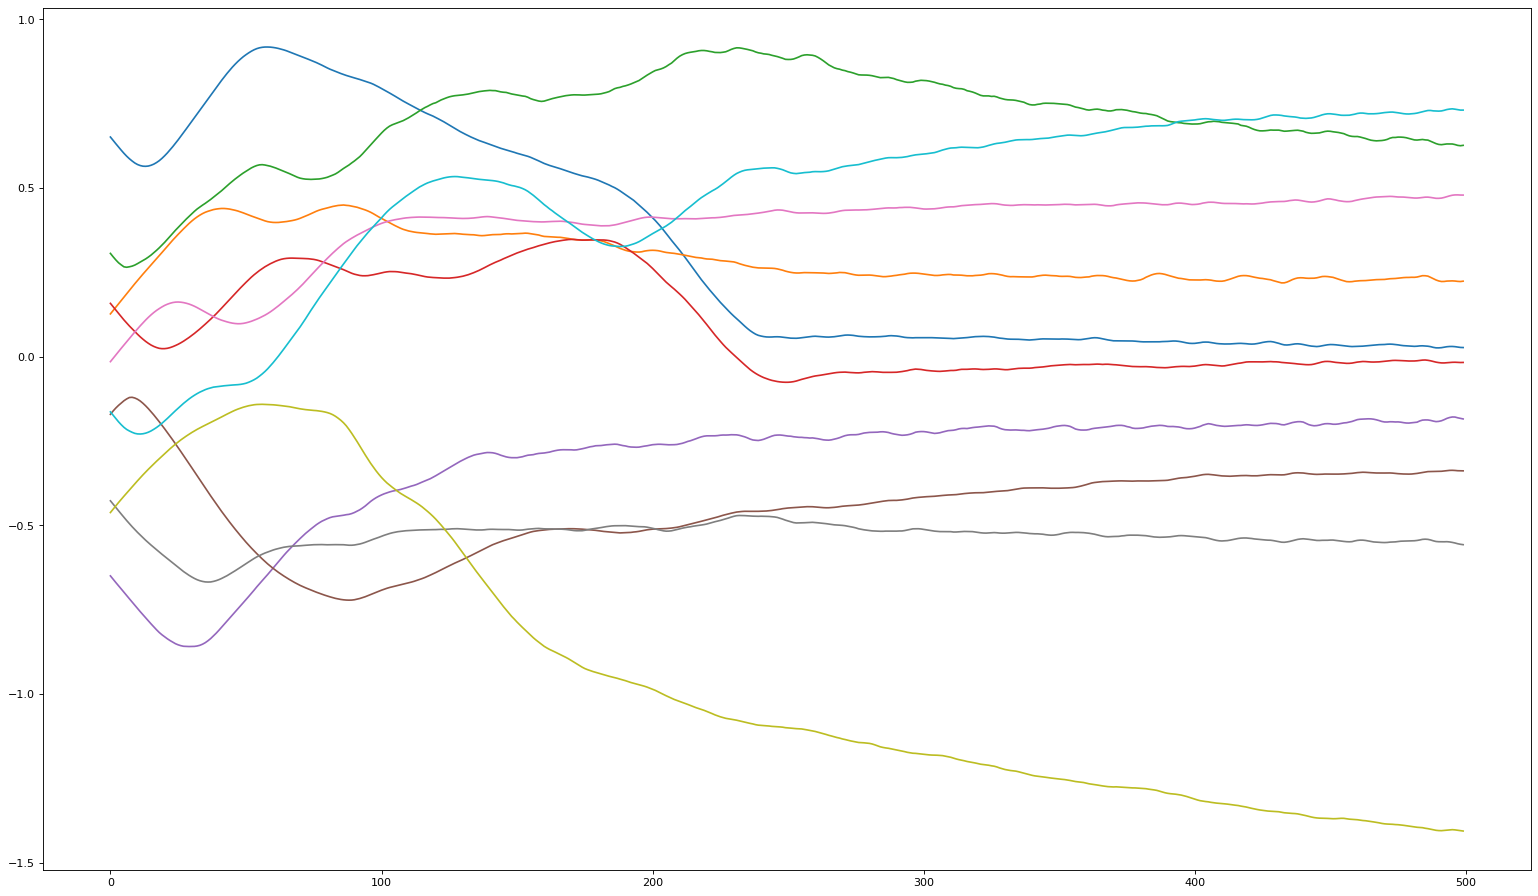

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(24, 14), dpi=80)
import numpy as np

ag = torch.stack(eweights, dim=-1) # (Neuron, feature, step)
print(ag.shape)
ag = ag[0, :, :]#.view(-1)
print(ag.shape)
for a in ag:
    plt.plot([float(x) for x in a])
    # plt.plot(np.cumsum([float(x) for x in a]))
    # plt.text(x[-1], y[-1], f'sample {i}')